# **Herramienta de Monitoreo de Liquidez Bancaria**

Este proyecto se realiza con el objetivo de crear esta herramienta pero intrínsicamente se realiza como introducción al área de riesgo de liquidez, para poner en prática sus conceptos y generar una sólida base en el tema.

Este notebook se separa de la siguiente manera:

1. Definición de los HQLA
2. Cálculo de LCR
3. GAP de Liquidez por tramos
4. Cálculo de NSFR
5. Escenarios de Estrés y CFP

# **Librerías**

Las librerías a utilizar son las siguientes:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Definición de los HQLA**

Partamos definiendo los HQLA y construyendo HQLA's artificiales para utilizarlos de manera conceptual.

Según **Basilea III**, un `Activo Líquido de Alta Calidad (HQLA)` es aquel que puede ser vendido de forma inmediata en mercados financieros profundos y líquidos, incluso en condiciones de estrés, con poco o ningún descuento en su valor.

Los activos líquidos se clasifican, segun Basilea III, en niveles. Veamos cuales son estos niveles:

| Nivel     | Activos incluidos      | Requisitos      |
| :--------------: | -------------- | -------------- |
| 1 | Efectivo, reservas en bancos centrales, bonos soberanos de alta calidad | Sin límite, no se descuentan |
| 2A | Bonos de empresas con alta calificación | Se descuentan un 15% y solo se pueden usar hasta 40% del HQLA |
| 2B | Acciones de alta calidad, bonos de menor calidad | Descuento mayor (25 - 50%) con límites estrictos |

Como podemos observar, la normativa impone límites máximos para incluir activos en nivel 2. Por un lado, la suma de los HQLA de los niveles 2A y 2B no puede representar más del 40% total de los HQLA y por otro lado, el nivel 2B no puede representar más del 15% total de los HQLA. Esto se hace para evitar que el banco dependa en exceso de activos menos líquidos.

Otro concepto clave es el `haircut`. El haircut es un descuento aplicado al valor de un activo para reflejar que no todo su valor de mercado puede ser usado inmediatamente en situaciones de estrés o venta forzada. En el siguiente paso, cuando veamos LCR, veremos que este concepto es importante para el cálculo de esta métrica.

El siguiente dataset contiene el nombre, el nivel, el monto y el haircut del HQLA.

In [2]:
activos_hqla = [
    {"nombre": "Efectivo en Banco Central", "nivel": "1", "monto": 30000000, "haircut": 0.00},
    {"nombre": "Bonos del Estado CLP", "nivel": "1", "monto": 20000000, "haircut": 0.00},
    {"nombre": "Bonos Corporativos AAA", "nivel": "2A", "monto": 10000000, "haircut": 0.15},
    {"nombre": "Acciones IPSA", "nivel": "2B", "monto": 5000000, "haircut": 0.50},
]

hqla_df = pd.DataFrame(activos_hqla)

Comencemos con las métricas que utilizaremos para el análisis del riesgo liquidez.

# **LCR (Liquid Coverage Ratio)**

EL `LCR` es una métrica diseñada por **Basilea III** para garantizar que un banco tenga suficiente liquidez para sobrevivir 30 días de estrés severo.

$$
LCR = \frac{Stock\ de\ HQLA}{Salidas\ netas\ de\ efectivo\ esperadas\ en\ 30\ dias} * 100
$$

El `stock de HQLA` es el monto neto total de HQLA, después de aplicar los haircuts y límites de elegibilidad definidos por Basilea III. Es decir, el stock de HQLA es la suma ponderada de todos los HQLA por sus respectivos haircuts.

Las `salidas netas` representan el monto que el banco espera tener que pagar en los próximos 30 días, descontando ciertas entradas permitidas. Se calcula restando a las salidas brutas el mínimo entre el 75% de las salidas brutas y las salidas brutas. Notemos que si las entradas brutas superan el 75% porciento de las salidas brutas entonces para cualquier valor de las entradas brutas el denominador del LCR sería el 25% de las salidas brutas.

Según la comisión **CMF** (Chile) el LCR debe ser al menos 100% (al igual que en Basilea III), es decir, los HQLA deben ser suficientes para cubrir las salidas netas previstas en 30 días y así poder enfrentar una crisis de liquidez a corto plazo.

Pasemos a ver el cálculo del LCR en nuestro dataset artifical:

In [12]:
# Stock de HQLA

# Partamos agregando al dataset una columna de los montos ponderados por sus
# respectivos haircuts a todos los HQLA

hqla_df["monto_neto"] = hqla_df["monto"] * (1 - hqla_df["haircut"])
stock_hqla = hqla_df["monto_neto"].sum()

# Salidas netas

# Supondremos salidas y entradas esperadas, para simplificar el proceso

salidas_esperadas = 50000000
entradas_esperadas = 15000000
limite_entradas = salidas_esperadas * 0.75
salidas_netas = salidas_esperadas - min(entradas_esperadas, limite_entradas)

# LCR

lcr = stock_hqla / salidas_netas * 100

print("LCR: {:.2f}% {}".format(lcr, "✅ Cumple (CMF)" if lcr >= 100 else "❌ Incumple (CMF)"))

LCR: 174.29% ✅ Cumple (CMF)


Añadiremos una manera personalizada para agregar las entradas y salidas esperadas, de forma más didáctica. Lo haremos a tráves de una validación para que solo se acepten valores positivos.

In [11]:
hqla_df["monto_neto"] = hqla_df["monto"] * (1 - hqla_df["haircut"])
stock_hqla = hqla_df["monto_neto"].sum()

def leer_flotante_positivo(mensaje):
    while True:
        try:
            valor = float(input(mensaje))
            if valor < 0:
                print("❌ El valor debe ser mayor o igual a 0.")
            else:
                return valor
        except ValueError:
            print("❌ Entrada inválida. Ingresa un número válido.")

salidas_esperadas = leer_flotante_positivo("Ingrese el monto total de SALIDAS esperadas: ")
entradas_esperadas = leer_flotante_positivo("Ingrese el monto total de ENTRADAS esperadas: ")
limite_entradas = salidas_esperadas * 0.75
salidas_netas = salidas_esperadas - min(entradas_esperadas, limite_entradas)

lcr = stock_hqla / salidas_netas * 100

print("LCR: {:.2f}% {}".format(lcr, "✅ Cumple (CMF)" if lcr >= 100 else "❌ Incumple (CMF)"))

Ingrese el monto total de SALIDAS esperadas: 50000000
Ingrese el monto total de ENTRADAS esperadas: 15000000
LCR: 174.29% ✅ Cumple (CMF)


# **Flujos de caja**

Crearemos una tabla de flujos de caja proyectados por tramos de vencimiento para realizar el cálculo del GAP.

In [13]:
tramos = ["0-7d", "8-30d", "31-90d", "91-180d", "181-365d"]
entradas = [8000000, 7000000, 10000000, 5000000, 3000000]
salidas = [10000000, 15000000, 8000000, 4000000, 2000000]

gap_df = pd.DataFrame({
    "tramo": tramos,
    "entradas": entradas,
    "salidas": salidas
})

# **GAP de liquidez**

El `GAP de liquidez` es una herramienta **interna** que compara las entradas y salidas de efectivo esperadas en distintos horizontes de tiempo, tales como 1, 7, 30 días, etc. Su objetivo es detectar si el banco tendrá deficit o superávit de efectivo en algún plazo y como se descalzan los flujos de caja

Para cada tramo de tiempo **t** tenemos:

$$
  GAP_t = Entradas\ de\ efectivo_t - Salidas\ de\ efectivo_t
$$
$$
  GAP\ Acumulado_t = \sum_{i=1}^tGAP_t
$$

Pasemos a ver el cálculo del GAP de liquidez:

In [15]:
# Le agregaremos al dataset dos columnas más para mostrar el GAP neto y el
# acumulado por tramo

# GAP neto por tramo

gap_df["gap_neto"] = gap_df["entradas"] - gap_df["salidas"]

# GAP acumulado por tramo

gap_df["gap_acumulado"] = gap_df["gap_neto"].cumsum()

# Mostremos el dataset para observar los GAP

gap_df

,tramo,entradas,salidas,gap_neto,gap_acumulado
0,0-7d,8000000,10000000,-2000000,-2000000
1,8-30d,7000000,15000000,-8000000,-10000000
2,31-90d,10000000,8000000,2000000,-8000000
3,91-180d,5000000,4000000,1000000,-7000000
4,181-365d,3000000,2000000,1000000,-6000000


Notemos que tenemos diferentes valores para los GAP, veamos como se interpretan estos distintos valores:

| GAP Neto | GAP Acumulado | Interpretación                                                                         | Riesgo    |
| -------- | ------------- | -------------------------------------------------------------------------------------- | --------- |
| **> 0**  | **> 0**       | Flujo positivo en el tramo y acumulado: la posición de liquidez mejora.                | ✅ Bajo    |
| **> 0**  | **< 0**       | Flujo positivo en el tramo actual, pero aún se arrastra déficit previo.                | ⚠️ Medio  |
| **> 0**  | **= 0**       | Flujo positivo que compensa déficit justo hasta el tramo actual.                       | ⚠️ Medio  |
| **= 0**  | **> 0**       | Equilibrio entre entradas y salidas en el tramo, manteniendo superávit acumulado.      | ✅ Bajo    |
| **= 0**  | **< 0**       | Equilibrio momentáneo, pero aún con déficit acumulado.                                 | ⚠️ Medio  |
| **= 0**  | **= 0**       | Equilibrio exacto entre entradas y salidas históricas: posición neutral.               | ⚠️ Neutro |
| **< 0**  | **> 0**       | Tramo con déficit, pero aún se mantiene superávit acumulado (se empieza a deteriorar). | ⚠️ Medio  |
| **< 0**  | **< 0**       | Tramo y acumulado en déficit: hay deterioro sostenido de liquidez.                     | ❌ Alto    |
| **< 0**  | **= 0**       | Déficit puntual que elimina todo el superávit anterior.                                | ❌ Crítico |


**Observación:** Como el GAP es una herramienta interna, las consideraciones del nivel de riesgo en cada tramo dependerá de los propios umbrales de riesgo establecidos por el banco. Estos umblares no son públicos por los que en este caso estamos tomando una suposición de ellos y únicamente se utiliza como ejemplo demostrativo.

Por lo tanto, en nuestro caso tenemos que:

In [102]:
# Construyamos una función que entregue las clasificaciones mostradas en la
# tabla anterior
def clasificar_riesgo(gap_neto, gap_acumulado):
        if gap_neto > 0 and gap_acumulado > 0:
            return "✅ Bajo"
        elif gap_neto > 0 and gap_acumulado <= 0:
            return "⚠️ Medio"
        elif gap_neto == 0 and gap_acumulado >= 0:
            return "✅ Bajo"
        elif gap_neto == 0 and gap_acumulado < 0:
            return "⚠️ Medio"
        elif gap_neto < 0 and gap_acumulado > 0:
            return "⚠️ Medio"
        elif gap_neto < 0 and gap_acumulado == 0:
            return "❌ Crítico"
        elif gap_acumulado == 0:
            return "⚠️ Neutro"
        else:
            return "❌ Alto"

# A través de apply() agreguemos una columna que evalue el riesgo por tramo
# (Bajo, Medio o Alto)

gap_df["Riesgo"] = gap_df.apply(lambda row: clasificar_riesgo(row["gap_neto"], row["gap_acumulado"]), axis=1)

print('-------------------------------------')
print('Tabla de análisis del GAP de liquidez')
print('-------------------------------------')
gap_df

-------------------------------------
Tabla de análisis del GAP de liquidez
-------------------------------------


,tramo,entradas,salidas,gap_neto,gap_acumulado,Riesgo
0,0-7d,8000000,10000000,-2000000,-2000000,❌ Alto
1,8-30d,7000000,15000000,-8000000,-10000000,❌ Alto
2,31-90d,10000000,8000000,2000000,-8000000,⚠️ Medio
3,91-180d,5000000,4000000,1000000,-7000000,⚠️ Medio
4,181-365d,3000000,2000000,1000000,-6000000,⚠️ Medio


# **Tablas de activos y pasivos**

Entender bien que son los activos y pasivos es fundamental en cualquier análisis financiero, especialmente en gestión de riesgo de liquidez. Veamos de que tratan estos conceptos:

* `Activos`: Representan todo lo que posee una entidad, que puede generar beneficios futuros. Son recursos económicos que tienen valor y que pueden convertirse en efectivo, generar ingresos o ser utilizados para operar el negocio. En un banco, los activos incluyen los préstamos otorgados, inversiones en bonos, efectivo, derivados, etc.

* `Pasivos`: Representan todo lo que debe una entidad. Son obligaciones financieras presentes que requieren una salida futura de recursos. En un banco, los pasivos incluyen los depósitos de clientes, deuda emitida, préstamos interbancarios, etc.

Estos conceptos tienen alta relación con la siguiente métrica que veremos. Procedamos a construir las tablas de activos y pasivos para su próxima utilización:

In [27]:
pasivos = [
    {"nombre": "Depósitos Minoristas Estables", "monto": 40000000, "factor_asf": 0.95},
    {"nombre": "Depósitos Minoristas No Estables", "monto": 30000000, "factor_asf": 0.90},
    {"nombre": "Deuda a Largo Plazo", "monto": 20000000, "factor_asf": 1.00},
]

activos = [
    {"nombre": "Préstamos a Empresas <1a", "monto": 25000000, "factor_rsf": 0.85},
    {"nombre": "Bonos a 2 años", "monto": 20000000, "factor_rsf": 0.85},
    {"nombre": "Derivados", "monto": 10000000, "factor_rsf": 1.00},
]

# **NSFR (Net Stable Funding Ratio)**

El `NSFR` es una métrica estructural de liquidez que busca asegurar que el banco no dependa excesivamente de financiamiento volátil para sostener activos que duran a largo plazo.

$$
  NSFR = \frac{Fondos\ Estables\ Disponibles\ (ASF)}{Requerimiento\ de\ Fondos\ Estables\ (RSF)}*100
$$

El `ASF` se define como la cantidad de fondeo estable y confiable, ponderado por su grado de estabilidad.

El `RSF` mide cuantos fondos estables necesita el banco, según el tipo de activos que posee.

La relación entre los activos y pasivos con el NSFR es directa y estructural, debido a que evalúa el equilibrio entre los pasivos estables y los activos que consumen liquidez.

Como podemos ver en las tablas, tanto los pasivos como los activos poseen un factor. Veamos a que se refiere este factor:

* Cada pasivo tiene un **factor ASF** según su **estabilidad**.

* Cada activo tiene un **factor RSF** según su **liquidez** y **plazo**.

Por lo tanto, tanto el ASF como el RSF se calculan como la suma ponderada de los activos y pasivos por sus factores, respectivamente.

Según la CMF, se está buscando llegar a un requerimiento de 100% como mínimo para la NSFR a contar de Enero del 2026. Hoy en día se está requeriendo 90% ya que desde 2022, se fue aumentando en un 10% (partió en 60%).

Pasemos a ver el cálculo del NSFR:

In [29]:
# Pasemos las tablas a dataframe para utilizarlas

asf_df = pd.DataFrame(pasivos)
rsf_df = pd.DataFrame(activos)

# Agreguemos al dataset los calculos de ASF y RSF por fila

asf_df["asf"] = asf_df["monto"] * asf_df["factor_asf"]
rsf_df["rsf"] = rsf_df["monto"] * rsf_df["factor_rsf"]

# Calculemos el ASF total y el RSF total

total_asf = asf_df["asf"].sum()
total_rsf = rsf_df["rsf"].sum()

# NSFR

nsfr = total_asf / total_rsf * 100

print("NSFR: {:.2f}% {}".format(nsfr, "✅ Cumple (CMF)" if nsfr >= 100 else "❌ Incumple (CMF)"))

NSFR: 176.17% ✅ Cumple (CMF)


# **Resumen**

Por último, veamos un resumen de todos los cálculos que realizamos.

In [33]:
print("===== HQLA Neto por Activo =====")
print(hqla_df[["nombre", "nivel", "monto", "haircut", "monto_neto"]])
print("\nTotal HQLA Neto: ${:,.0f}".format(stock_hqla))
print("Salidas netas ajustadas: ${:,.0f}".format(salidas_netas))
print("🔍 LCR: {:.2f}% {}".format(lcr, "✅ Cumple" if lcr >= 100 else "❌ Incumple"))
print('================================')

print("\n===== GAP de Liquidez por Tramos =====")
print(gap_df)
if any(gap_df["gap_acumulado"] < 0):
    print("⚠️ Alerta: Existe un tramo con GAP acumulado negativo. Riesgo de iliquidez.")
else:
    print("✅ Todos los tramos mantienen GAP acumulado positivo.")
print('========================================')

print("\n===== NSFR: Funding Estable =====")
print("\n-- ASF --")
print(asf_df[["nombre", "monto", "factor_asf", "asf"]])

print("\n-- RSF --")
print(rsf_df[["nombre", "monto", "factor_rsf", "rsf"]])

print("\nTotal ASF: ${:,.0f}".format(total_asf))
print("Total RSF: ${:,.0f}".format(total_rsf))
print("🔍 NSFR: {:.2f}% {}".format(nsfr, "✅ Cumple" if nsfr >= 100 else "❌ Incumple"))


===== HQLA Neto por Activo =====
                      nombre nivel     monto  haircut  monto_neto
0  Efectivo en Banco Central     1  30000000     0.00  30000000.0
1       Bonos del Estado CLP     1  20000000     0.00  20000000.0
2     Bonos Corporativos AAA    2A  10000000     0.15   8500000.0
3              Acciones IPSA    2B   5000000     0.50   2500000.0

Total HQLA Neto: $61,000,000
Salidas netas ajustadas: $35,000,000
🔍 LCR: 174.29% ✅ Cumple

===== GAP de Liquidez por Tramos =====
      tramo  entradas   salidas  gap_neto  gap_acumulado    Riesgo
0      0-7d   8000000  10000000  -2000000       -2000000    ❌ Alto
1     8-30d   7000000  15000000  -8000000      -10000000    ❌ Alto
2    31-90d  10000000   8000000   2000000       -8000000  ⚠️ Medio
3   91-180d   5000000   4000000   1000000       -7000000  ⚠️ Medio
4  181-365d   3000000   2000000   1000000       -6000000  ⚠️ Medio
⚠️ Alerta: Existe un tramo con GAP acumulado negativo. Riesgo de iliquidez.

===== NSFR: Funding Estable

# **Escenarios de estrés y CFP**

## **Escenario de Estrés**

Los escenarios de estrés son uno de los pilares más importantes en la gestión del riesgo de liquidez (y de los riesgos financieros en general), especialmente exigidos por Basilea III y por la CMF.

Un `escenario de estrés` es una simulación o proyección que busca evaluar como se comportaría la situación financiera de una institución ante condiciones extremas pero plausibles, que pudieran generar tensiones en la liquidez o solvencia. En palabras más informales, es poner al banco en situaciones donde las cosas salen mal para ver su tolerancia y resistencia.

El objetivo es evaluar si el banco tiene suficiente liquidez o capital para sobrevivir a situaciones adversas de corto o mediano plazo, sin caer en default, iliquidez o incumplir normativa.

Entre los distintos escenarios tenemos los siguientes:

* Pérdida masiva de depósitos
* Downgrade crediticio
* Caída del valor de los activos
* Crisis macroeconómica
* Incumplimiento de contraparte
* Rumores o crisis de reputación

Para construir estos escenarios se tiene que identificar los supuestos adversos (realistas), definir los impactos cuantitativos esperados, hacer un recálculo de las métricas claves bajo estas condiciones y diseñar respuestas (activar CFP si es necesario).

La CMF exige que los bancos realicen pruebas de estrés internas periódicamente.

Veamos dos escenarios de estrés y como afecta en las métricas que definian nuestra institución financiera anteriormente.

Partamos copiando los dataset para no afectar en los resultados anteriores:


In [58]:
activos_hqla_base = activos_hqla.copy()
pasivos_base = pasivos.copy()
activos_base = activos.copy()
salidas_esperadas_base = salidas_esperadas
entradas_esperadas_base = entradas_esperadas
entradas_base = entradas.copy()
salidas_base = salidas.copy()

En función de automatizar los procesos de cálculo, se crea una función que calculen las métricas para los distintos escenarios.

In [96]:
# Función para el cálculo de las métricas HQLA, GAP y NSFR
def calcular_metricas(activos_hqla,
                      pasivos,
                      activos,
                      salidas_esperadas,
                      entradas_esperadas,
                      entradas_gaps,
                      salidas_gaps):
    # HQLA neto
    hqla_df = pd.DataFrame(activos_hqla)
    hqla_df["monto_neto"] = hqla_df["monto"] * (1 - hqla_df["haircut"])
    total_hqla_neto = hqla_df["monto_neto"].sum()
    limite_entradas = salidas_esperadas * 0.75
    salidas_netas = salidas_esperadas - min(entradas_esperadas, limite_entradas)
    lcr = total_hqla_neto / salidas_netas * 100

    # GAP
    gap_df = pd.DataFrame({
        "tramo": tramos,
        "entradas": entradas_gaps,
        "salidas": salidas_gaps
    })
    gap_df["gap_neto"] = gap_df["entradas"] - gap_df["salidas"]
    gap_df["gap_acumulado"] = gap_df["gap_neto"].cumsum()

    # NSFR
    asf_df = pd.DataFrame(pasivos)
    asf_df["asf"] = asf_df["monto"] * asf_df["factor_asf"]
    total_asf = asf_df["asf"].sum()

    rsf_df = pd.DataFrame(activos)
    rsf_df["rsf"] = rsf_df["monto"] * rsf_df["factor_rsf"]
    total_rsf = rsf_df["rsf"].sum()

    nsfr = total_asf / total_rsf * 100

    return {
        "lcr": lcr,
        "gap_df": gap_df,
        "nsfr": nsfr,
        "hqla_df": hqla_df,
        "asf_df": asf_df,
        "rsf_df": rsf_df,
        "total_hqla_neto": total_hqla_neto,
        "salidas_netas": salidas_netas,
        "total_asf": total_asf,
        "total_rsf": total_rsf
    }

## **Escenario Base**

Partamos con el cálculo de las métricas del escenario base, sin ninguna modificación.

In [97]:
metrics_base = calcular_metricas(activos_hqla_base,
                                 pasivos_base,
                                 activos_base,
                                 salidas_esperadas_base,
                                 entradas_esperadas_base,
                                 entradas_base,
                                 salidas_base)

## **Escenario de estrés**

Supondremos una fuga masiva, aumento de salidas inesperadas y disminución de entradas inesperadas.

Para la fuga masiva de depósitos minoristas no estables supondremos una pérdida del 70% de los depósitos, para los estables una pérdida del 60% de los depósitos. Esto afectará en el cáculo del NSFR.

Para el aumento de salidas inesperadas supondremos un 50% más de salidas inesperadas y además un 35% menos de entradas en todos los tramos. Esto afectará en el GAP de liquidez y el LCR.

Hagamos la modificación de los datos y recalculemos las métricas:

In [109]:
# Modificación datos NSFR
pasivos_stress1 = [
    {"nombre": "Depósitos Minoristas Estables", "monto": 40000000*0.4, "factor_asf": 0.95},
    {"nombre": "Depósitos Minoristas No Estables", "monto": 30000000*0.3, "factor_asf": 0.90},
    {"nombre": "Deuda a Largo Plazo", "monto": 20000000, "factor_asf": 1.00},
]

# Modificación datos LCR
salidas_esperadas_stress1 = salidas_esperadas_base * 1.5
entradas_esperadas_stress1 = entradas_esperadas_base * 0.65

# Modificación datos GAP
entradas_stress1 = [e * 0.65 for e in entradas_base]
salidas_stress1 = [s * 1.4 for s in salidas_base]

# Recálculo de las métricas
metrics_stress1 = calcular_metricas(activos_hqla_base,
                                    pasivos_stress1,
                                    activos_base,
                                    salidas_esperadas_stress1,
                                    entradas_esperadas_stress1,
                                    entradas_stress1,
                                    salidas_stress1)

## **Plan de Contingencia de Liquidez (CFP)**

Ante las diferentes problemáticas se procede a realizar el `Plan de Contingencia de Liquidez (CFP)`. Este plan es un documento estratégico y operativo que describe que acciones tomará un banco si enfrenta una situación de estrés de liquidez, con el objetivo de seguir cumpliendo sus obligaciones sin colapsar.

En este caso, las acciones a realizar sobre el escenario 1 serán una línea de crédito contigente de 10 millones y una venta rápida de activos que se liquidan en 5 millones para aumentar los HQLA.



In [110]:
linea_credito_contingente = 10000000
venta_rapida_activos = 5000000

# Ajustamos LCR y NSFR considerando uso CFP
total_hqla_neto_cfp = metrics_stress1["total_hqla_neto"] + venta_rapida_activos
total_asf_cfp = metrics_stress1["total_asf"] + linea_credito_contingente

lcr_cfp = total_hqla_neto_cfp / metrics_stress1["salidas_netas"] * 100
nsfr_cfp = total_asf_cfp / metrics_stress1["total_rsf"] * 100

Ahora, en función de automatizar la entrega de los resultados y evitar la escritura repetiva de código se crea una función que generará los informes para cada escenario.

In [108]:
# Función de entrega de resultados
def mostrar_resultados(nombre, metrics, lcr_cfp_val=None, nsfr_cfp_val=None):
    print(f"\n===== Resultados {nombre} =====")
    print(f"LCR: {metrics['lcr']:.2f}% {'✅ Cumple' if metrics['lcr'] >= 100 else '❌ Incumple'}")
    print(f"NSFR: {metrics['nsfr']:.2f}% {'✅ Cumple' if metrics['nsfr'] >= 100 else '❌ Incumple'}")
    if any(metrics["gap_df"]["gap_acumulado"] < 0):
        print("⚠️ Alerta: GAP acumulado negativo detectado. Riesgo de iliquidez.")
    else:
        print("✅ GAP acumulado positivo en todos los tramos.")
    if lcr_cfp_val:
        print(f"Con CFP, LCR ajustado: {lcr_cfp_val:.2f}% {'✅ Cumple' if lcr_cfp_val >= 100 else '❌ Incumple'}")
    if nsfr_cfp_val:
        print(f"Con CFP, NSFR ajustado: {nsfr_cfp_val:.2f}% {'✅ Cumple' if nsfr_cfp_val >= 100 else '❌ Incumple'}")

Por último, visualicemos los resultados

In [111]:
mostrar_resultados("Escenario Base", metrics_base)
mostrar_resultados("Escenario Estrés 1 (fuga depósitos)", metrics_stress1, lcr_cfp, nsfr_cfp)


===== Resultados Escenario Base =====
LCR: 174.29% ✅ Cumple
NSFR: 176.17% ✅ Cumple
⚠️ Alerta: GAP acumulado negativo detectado. Riesgo de iliquidez.

===== Resultados Escenario Estrés 1 (fuga depósitos) =====
LCR: 93.49% ❌ Incumple
NSFR: 89.74% ❌ Incumple
⚠️ Alerta: GAP acumulado negativo detectado. Riesgo de iliquidez.
Con CFP, LCR ajustado: 101.15% ✅ Cumple
Con CFP, NSFR ajustado: 110.47% ✅ Cumple


## **Visualización comparativa**

Realicemos un gráfico comparativo de los distintos escenarios. Las líneas trazadas representan el desarrollo desde el escenario base, la problemática planteada y el plan de contigencia aplicado.

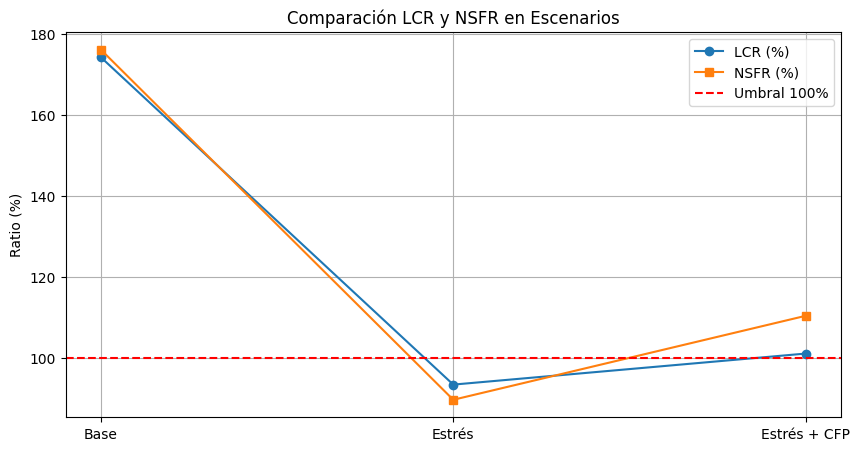

In [124]:
escenarios = ["Base", "Estrés", "Estrés + CFP"]
lcr_vals = [metrics_base["lcr"], metrics_stress1["lcr"], lcr_cfp]
nsfr_vals = [metrics_base["nsfr"], metrics_stress1["nsfr"], nsfr_cfp]

plt.figure(figsize=(10,5))
plt.plot(escenarios, lcr_vals, marker='o', label='LCR (%)')
plt.plot(escenarios, nsfr_vals, marker='s', label='NSFR (%)')
plt.axhline(100, color='r', linestyle='--', label='Umbral 100%')

plt.title('Comparación LCR y NSFR en Escenarios')
plt.ylabel('Ratio (%)')
plt.legend()
plt.grid(True)
plt.show()